In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, KFold, GridSearchCV,\
cross_val_score, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, make_scorer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import tree 
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

# Modeling

In [21]:
df_final = pd.read_csv('Final_NBA_Seasons1-3_1977_final.csv', index_col = 0)
# df_final.set_index('Player', inplace = True)
full_df = pd.read_csv('Final_NBA_PLayers_updated.csv', index_col = 0)

Adding in rookie season to our final data set, through strech goal year-over-year analysis it showed that player age, season count and statistics fluctuate year over year.

In [22]:
rookie_df = full_df[full_df['season_count'] == 1]
rookie_df = rookie_df[['Player','Season']]
# rookie_df.set_index('Player', inplace = True)
rookie_df.head()

,Player,Season
0,A.C. Green\greenac01,1985-86
16,A.J. Bramlett\bramlaj01,1999-00
17,A.J. English\engliaj01,1990-91
19,A.J. Guyton\guytoaj01,2000-01
22,A.J. Hammons\hammoaj01,2016-17


In [81]:
#merging rookie season into final dataset
df = df_final.merge(rookie_df, how = 'left', on = 'Player')


In [82]:
#breaking season and coverting into integer to be processed in model
df['year_split'] = df['Season'].str.split('-')
df['award_year'] = [x[1] for x in df['year_split']]
df['season_year'] = [x[0] for x in df['year_split']]
df['season_year'] = df['season_year'].astype(int)
df.head()

,Player,G,GS,MP,FG,FGA,2P,2PA,3P,3PA,...,USG_1-2,USG_2-3,VORP_1-2,VORP_2-3,target,Qualified,Season,year_split,award_year,season_year
0,A.C. Green\greenac01,243,137.0,6418.0,847,1615,846,1602,1.0,13.0,...,0.0,0.0,1.5,-0.2,0,1.0,1985-86,"[1985, 86]",86,1985
1,A.J. Price\priceaj01,150,3.0,2228.0,318,848,191,437,127.0,411.0,...,0.0,-5.0,-0.5,0.3,0,1.0,2009-10,"[2009, 10]",10,2009
2,Aaron Brooks\brookaa01,213,117.0,5525.0,984,2339,626,1396,358.0,943.0,...,1.1,2.8,0.3,1.3,0,1.0,2007-08,"[2007, 08]",08,2007
3,Aaron Gordon\gordoaa01,205,117.0,4958.0,760,1652,628,1195,132.0,457.0,...,1.8,2.8,1.6,-0.8,0,1.0,2014-15,"[2014, 15]",15,2014
4,Aaron Gray\grayaa01,149,19.0,1639.0,226,453,226,451,0.0,2.0,...,-7.5,1.9,0.0,0.3,0,1.0,2007-08,"[2007, 08]",08,2007


In [132]:
#final columns selected after correlation analysis
cols = ['MP','FG','2P','FT','TRB','AST','STL','TOV','PTS','roy','all_rookie_1','all_rookie_2','WS_1','GS_1','MP_1','PTS_1','ppg_1','apg_1','rpg_1','spg_1','bpg_1',
        'tpg_1','ftpg_1','PER_1','WS/48_1','VORP_1','WS_2','GS_2','MP_2','ppg_2','apg_2','rpg_2','spg_2','bpg_2','tpg_2','ftpg_2','PER_2','USG%_2',
        'ORtg_2','DRtg_2','OWS_2','DWS_2','WS/48_2','VORP_2','WS_3','GS_3','MP_3','PTS_3','TS%_3','ppg_3','apg_3','rpg_3','spg_3','bpg_3','tpg_3','ftpg_3','PER_3','USG%_3',
        'ORtg_3','DRtg_3','OWS_3','DWS_3','WS/48_3','VORP_3','VORP_1-2','VORP_2-3','season_year','target',]

df = df[cols]
df = df.fillna(0)
df.head()

,MP,FG,2P,FT,TRB,AST,STL,TOV,PTS,roy,...,ORtg_3,DRtg_3,OWS_3,DWS_3,WS/48_3,VORP_3,VORP_1-2,VORP_2-3,season_year,target
0,6418.0,847,846,615,1706.0,231,206.0,321.0,2310,0.0,...,119.0,106.0,4.5,3.4,0.144,1.5,1.5,-0.2,1985,0
1,2228.0,318,191,142,221.0,303,84.0,144.0,905,0.0,...,100.0,106.0,0.2,0.5,0.063,0.1,-0.5,0.3,2009,0
2,5525.0,984,626,436,428.0,759,128.0,401.0,2762,0.0,...,108.0,112.0,3.9,1.6,0.091,1.9,0.3,1.3,2007,0
3,4958.0,760,628,329,1081.0,311,145.0,193.0,1981,0.0,...,107.0,111.0,2.0,1.7,0.077,0.6,1.6,-0.8,2014,0
4,1639.0,226,226,110,494.0,109,44.0,115.0,562,0.0,...,115.0,106.0,0.5,0.4,0.142,0.1,0.0,0.3,2007,0


In [136]:
# create function to call for evaluation of each model
def metrics_score(train_preds, y_train, test_preds, y_test):
    print(f"Training Accuracy:\t{accuracy_score(y_train, train_preds):.4}",
          f"\tTesting Accuracy:\t{accuracy_score(y_test, test_preds):.4}")
    print(f"Training Precision:\t{precision_score(y_train, train_preds):.4}",
          f"\tTesting Precision:\t{precision_score(y_test, test_preds):.4}")
    print(f"Training Recall:\t{recall_score(y_train, train_preds):.4}",
          f"\tTesting Recall:\t\t{recall_score(y_test, test_preds):.4}")
    print(f"Training F1:\t\t{f1_score(y_train, train_preds):.4}",
          f"\tTesting F1:\t\t{f1_score(y_test, test_preds):.4}")
#defining which metric our models will focus on
scorer = make_scorer(precision_score, average='weighted')

In [137]:
#splitting our dataset into training and testing
X = df.drop(columns = 'target')
y = df['target']

X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size= .8, random_state= 42)

In [138]:
nba_scaled = StandardScaler()

nba_scaled.fit(X_train)
X_train_sc = pd.DataFrame(nba_scaled.transform(X_train), index = X_train.index, columns = X_train.columns)
X_test_sc = pd.DataFrame(nba_scaled.transform(X_test), index = X_test.index, columns = X_test.columns)

## Baseline Random Forest Model

In [139]:
rf = RandomForestClassifier(class_weight = 'balanced', random_state = 42)

In [140]:
rf.fit(X_train_sc, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [141]:
rfbase_train_preds = rf.predict(X_train_sc)
rfbase_test_preds = rf.predict(X_test_sc)
metrics_score(rfbase_train_preds, y_train, rfbase_test_preds, y_test)

Training Accuracy:	1.0 	Testing Accuracy:	0.9373
Training Precision:	1.0 	Testing Precision:	0.6
Training Recall:	1.0 	Testing Recall:		0.3333
Training F1:		1.0 	Testing F1:		0.4286


Baseline Random Forest Model w/ all features is way too overfit on the training set and does not perform well on the validation set.

## Random Forest RFE Feature Selection

In [142]:
rfe_rf = RFECV(estimator=RandomForestClassifier(class_weight = 'balanced', random_state = 42), step = 1, cv = 3, scoring = 'precision', n_jobs = -1, verbose = 1)
rfe_rf.fit(X_train_sc, y_train)
X_train_sc.columns[rfe_rf.get_support()]

Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 fe

Index(['PTS', 'WS_2', 'PER_2', 'VORP_2', 'PER_3', 'VORP_3'], dtype='object')

In [143]:
rf_cols =['PTS', 'WS_2', 'PER_2', 'VORP_2', 'PER_3', 'VORP_3', 'season_year']

## Random Forest Baseline w/ RFE + Season

In [144]:
rf = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
rf.fit(X_train_sc[rf_cols], y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [145]:
rfbaserfe_train_preds = rf.predict(X_train_sc[rf_cols])
rfbaserfe_test_preds = rf.predict(X_test_sc[rf_cols])
metrics_score(rfbaserfe_train_preds, y_train, rfbaserfe_test_preds, y_test)

Training Accuracy:	1.0 	Testing Accuracy:	0.9373
Training Precision:	1.0 	Testing Precision:	0.5714
Training Recall:	1.0 	Testing Recall:		0.4444
Training F1:		1.0 	Testing F1:		0.5


Our baseline model with RFE selected features continues to be overfit to the training set and underperform on the validation set. 

## Random Forest Grid Search w/ RFE Selected Features

In [146]:
rf_cols =['PTS', 'WS_2', 'PER_2', 'VORP_2', 'PER_3', 'VORP_3', 'season_year']

params = { 
    'n_estimators': [10, 25, 50, 100, 200, 500],
    'max_features': ['sqrt', 'auto', 'log2'],
    'max_depth' : [2,4,6,8,10,12,15,20],
    'criterion' :['gini', 'entropy']
}

rf = RandomForestClassifier(random_state = 42)

grid_search_RF = GridSearchCV(estimator=rf, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

In [147]:
grid_search_RF.fit(X_train_sc[rf_cols], y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  6.6min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 15, 20],
                         'max_features': ['sqrt', 'auto', 'log2'],
                         'n_estimators': [10, 25, 50, 100, 200, 500]},
             scoring=make_scorer(precision_score, average=weighted), verbose=2)

In [148]:
grid_search_RF.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'n_estimators': 50}

In [149]:
rf_train_preds = grid_search_RF.best_estimator_.predict(X_train_sc[rf_cols])
rf_test_preds = grid_search_RF.best_estimator_.predict(X_test_sc[rf_cols])
metrics_score(rf_train_preds, y_train, rf_test_preds, y_test)

Training Accuracy:	0.9833 	Testing Accuracy:	0.9529
Training Precision:	1.0 	Testing Precision:	0.75
Training Recall:	0.7639 	Testing Recall:		0.5
Training F1:		0.8661 	Testing F1:		0.6


Feature: 0, Score: 0.13861
Feature: 1, Score: 0.10233
Feature: 2, Score: 0.10827
Feature: 3, Score: 0.12096
Feature: 4, Score: 0.21247
Feature: 5, Score: 0.24169
Feature: 6, Score: 0.07567


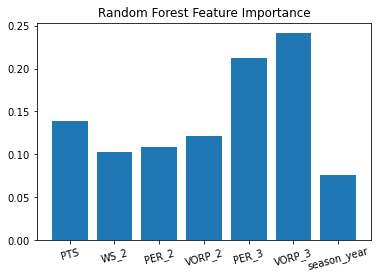

In [150]:
importance = grid_search_RF.best_estimator_.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([0,1,2,3,4,5,6],['PTS', 'WS_2', 'PER_2', 'VORP_2', 'PER_3', 'VORP_3', 'season_year'], rotation = 15)
plt.title('Random Forest Feature Importance')
plt.savefig('Feature_Importance_transparent',
           transparent = True)
plt.show()

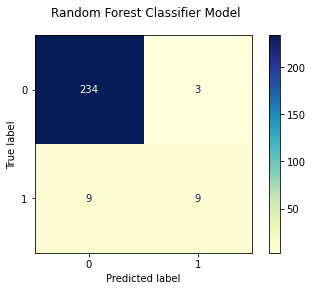

In [151]:
fig, ax = plt.subplots()

fig.suptitle("Random Forest Classifier Model")

plot_confusion_matrix(grid_search_RF, X_test_sc[rf_cols], y_test, ax=ax, cmap="YlGnBu");

plt.savefig('Confusion_updated',
           transparent = True)

### Random Forest RFE w/ Grid-search + SMOTE Resampling

In [152]:
sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_sample(X_train_sc[rf_cols], y_train.ravel())

params = { 
    'n_estimators': [10, 25, 50, 100, 200, 500],
    'max_features': ['sqrt', 'auto', 'log2'],
    'max_depth' : [2,4,6,8,10,12,15,20],
    'criterion' :['gini', 'entropy']
}

rf = RandomForestClassifier(random_state = 42)

grid_search_RF_sm = GridSearchCV(estimator=rf, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

grid_search_RF_sm.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 385 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1033 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.8min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 15, 20],
                         'max_features': ['sqrt', 'auto', 'log2'],
                         'n_estimators': [10, 25, 50, 100, 200, 500]},
             scoring=make_scorer(precision_score, average=weighted), verbose=2)

In [153]:
grid_search_RF_sm.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [154]:
rf_train_preds_sm = grid_search_RF_sm.best_estimator_.predict(X_train_res)
rf_test_preds_sm = grid_search_RF_sm.best_estimator_.predict(X_test_sc[rf_cols])
metrics_score(rf_train_preds_sm, y_train_res, rf_test_preds_sm, y_test)

Training Accuracy:	1.0 	Testing Accuracy:	0.9216
Training Precision:	1.0 	Testing Precision:	0.4643
Training Recall:	1.0 	Testing Recall:		0.7222
Training F1:		1.0 	Testing F1:		0.5652


## Logistic Regression

### Baseline Model

In [155]:
lr = LogisticRegression(class_weight = 'balance', random_state = 42)
lr.fit(X_train_sc, y_train)

lrbase_train_preds = lr.predict(X_train_sc)
lrbase_test_preds = lr.predict(X_test_sc)
metrics_score(lrbase_train_preds, y_train, lrbase_test_preds, y_test)

Training Accuracy:	0.9558 	Testing Accuracy:	0.9373
Training Precision:	0.8 	Testing Precision:	0.5625
Training Recall:	0.5 	Testing Recall:		0.5
Training F1:		0.6154 	Testing F1:		0.5294


## Logistic Regression w/ RFE

In [156]:
X_train_sc.head()

,MP,FG,2P,FT,TRB,AST,STL,TOV,PTS,roy,...,USG%_3,ORtg_3,DRtg_3,OWS_3,DWS_3,WS/48_3,VORP_3,VORP_1-2,VORP_2-3,season_year
490,0.943454,0.947423,0.398373,1.540453,-0.401482,1.771461,0.673271,0.993256,1.293784,-0.183037,...,1.520879,0.902097,0.867052,2.176889,-0.224027,0.974407,1.689118,-0.366980,1.791781,1.362916
405,0.096102,0.022652,-0.220105,-0.225004,0.571891,-0.502083,-0.122284,-0.489410,0.058572,-0.183037,...,-0.055443,0.049858,-0.983774,-0.287171,0.884982,0.535562,-0.221069,1.082430,-0.884010,0.906549
156,-0.500480,-0.729920,-0.876000,-0.998549,-1.014415,0.061605,-0.568570,-0.598030,-0.742134,-0.183037,...,-1.084431,-1.181154,1.052135,-0.938054,-1.333036,-1.595971,-1.282284,-0.125411,-1.205105,0.176361
650,-0.769544,-0.793698,-0.735137,-0.802387,-0.677760,-0.558452,-0.432744,-0.983632,-0.825250,-0.183037,...,-0.799817,0.333938,0.867052,-0.333662,-0.620102,-0.310782,-0.362564,-0.246196,-0.134788,-0.553828
770,-0.127002,-0.100651,-0.211301,-0.169487,-0.474668,-0.158501,-0.015563,-0.402514,-0.075564,-0.183037,...,0.075917,0.902097,1.237217,0.038271,-0.936962,0.222101,-0.150321,1.323998,-0.884010,-0.280007


In [157]:
rfe_lr = RFECV(estimator=LogisticRegression(class_weight = 'balanced', max_iter = 1000), step = 1, cv = 3, scoring = 'precision', n_jobs = -1, verbose = 1)
rfe_lr.fit(X_train_sc, y_train)
X_train_sc.columns[rfe_lr.get_support()]

Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 fe

Index(['2P', 'TRB', 'PTS', 'spg_1', 'tpg_1', 'MP_2', 'bpg_2', 'PER_2', 'MP_3',
       'TS%_3', 'spg_3', 'PER_3', 'VORP_3'],
      dtype='object')

In [158]:
lr_cols = ['2P', 'TRB', 'PTS', 'spg_1', 'tpg_1', 'MP_2', 'bpg_2', 'PER_2', 'MP_3',
       'TS%_3', 'spg_3', 'PER_3', 'VORP_3', 'season_year']

In [159]:
X_train_sc[lr_cols].corr()

,2P,TRB,PTS,spg_1,tpg_1,MP_2,bpg_2,PER_2,MP_3,TS%_3,spg_3,PER_3,VORP_3,season_year
2P,1.000000,0.752948,0.961977,0.564395,0.700540,0.794024,0.327550,0.627135,0.759072,0.287028,0.558332,0.596094,0.643094,-0.293510
TRB,0.752948,1.000000,0.702601,0.333466,0.471621,0.669657,0.603728,0.545663,0.647238,0.310550,0.313820,0.517104,0.508001,-0.134946
PTS,0.961977,0.702601,1.000000,0.608713,0.733541,0.835116,0.259483,0.633662,0.796804,0.314160,0.603171,0.609791,0.694026,-0.180591
spg_1,0.564395,0.333466,0.608713,1.000000,0.757831,0.528539,0.028762,0.370467,0.422597,0.089536,0.677636,0.337423,0.491409,-0.165677
tpg_1,0.700540,0.471621,0.733541,0.757831,1.000000,0.557795,0.162851,0.414641,0.446124,0.116180,0.490676,0.379465,0.483027,-0.236445
MP_2,0.794024,0.669657,0.835116,0.528539,0.557795,1.000000,0.310852,0.535659,0.678924,0.211218,0.520144,0.409365,0.500771,-0.121784
bpg_2,0.327550,0.603728,0.259483,0.028762,0.162851,0.310852,1.000000,0.350039,0.237106,0.121907,0.027747,0.275623,0.276091,-0.061570
PER_2,0.627135,0.545663,0.633662,0.370467,0.414641,0.535659,0.350039,1.000000,0.488120,0.301426,0.415372,0.581705,0.566160,-0.046919
MP_3,0.759072,0.647238,0.796804,0.422597,0.446124,0.678924,0.237106,0.488120,1.000000,0.401441,0.643711,0.553914,0.659984,-0.092109
TS%_3,0.287028,0.310550,0.314160,0.089536,0.116180,0.211218,0.121907,0.301426,0.401441,1.000000,0.237658,0.630986,0.415196,-0.018562


In [160]:
#dropping features that are over .9 correlated with eachother (2P)

lr_cols = ['TRB', 'PTS', 'spg_1', 'tpg_1', 'MP_2', 'bpg_2', 'PER_2', 'MP_3',
       'TS%_3', 'spg_3', 'PER_3', 'VORP_3', 'season_year']

X_train_sc[lr_cols].corr()

,TRB,PTS,spg_1,tpg_1,MP_2,bpg_2,PER_2,MP_3,TS%_3,spg_3,PER_3,VORP_3,season_year
TRB,1.000000,0.702601,0.333466,0.471621,0.669657,0.603728,0.545663,0.647238,0.310550,0.313820,0.517104,0.508001,-0.134946
PTS,0.702601,1.000000,0.608713,0.733541,0.835116,0.259483,0.633662,0.796804,0.314160,0.603171,0.609791,0.694026,-0.180591
spg_1,0.333466,0.608713,1.000000,0.757831,0.528539,0.028762,0.370467,0.422597,0.089536,0.677636,0.337423,0.491409,-0.165677
tpg_1,0.471621,0.733541,0.757831,1.000000,0.557795,0.162851,0.414641,0.446124,0.116180,0.490676,0.379465,0.483027,-0.236445
MP_2,0.669657,0.835116,0.528539,0.557795,1.000000,0.310852,0.535659,0.678924,0.211218,0.520144,0.409365,0.500771,-0.121784
bpg_2,0.603728,0.259483,0.028762,0.162851,0.310852,1.000000,0.350039,0.237106,0.121907,0.027747,0.275623,0.276091,-0.061570
PER_2,0.545663,0.633662,0.370467,0.414641,0.535659,0.350039,1.000000,0.488120,0.301426,0.415372,0.581705,0.566160,-0.046919
MP_3,0.647238,0.796804,0.422597,0.446124,0.678924,0.237106,0.488120,1.000000,0.401441,0.643711,0.553914,0.659984,-0.092109
TS%_3,0.310550,0.314160,0.089536,0.116180,0.211218,0.121907,0.301426,0.401441,1.000000,0.237658,0.630986,0.415196,-0.018562
spg_3,0.313820,0.603171,0.677636,0.490676,0.520144,0.027747,0.415372,0.643711,0.237658,1.000000,0.502415,0.657844,-0.148423


### Logistic Regression w/ RFE Columns

In [161]:
lr = LogisticRegression(class_weight = 'balance', random_state = 42)
lr.fit(X_train_sc[lr_cols], y_train)

lrbaserfe_train_preds = lr.predict(X_train_sc[lr_cols])
lrbaserfe_test_preds = lr.predict(X_test_sc[lr_cols])
metrics_score(lrbaserfe_train_preds, y_train, lrbaserfe_test_preds, y_test)

Training Accuracy:	0.9528 	Testing Accuracy:	0.9451
Training Precision:	0.7609 	Testing Precision:	0.625
Training Recall:	0.4861 	Testing Recall:		0.5556
Training F1:		0.5932 	Testing F1:		0.5882


### Logistic Regression w/ RFE & Grid-search

In [162]:
C = np.logspace(0, 1, 10)

params = dict(C=C, max_iter=[50, 100], class_weight = ['balanced', None])

logistic = LogisticRegression(penalty='l2', random_state=42)

grid_search_LR = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = params, 
                              cv = 3, n_jobs = -1, verbose = 2)

grid_search_LR.fit(X_train_sc[lr_cols], y_train)

lrgsrfe_train_preds = grid_search_LR.best_estimator_.predict(X_train_sc[lr_cols])
lrgsrfe_test_preds = grid_search_LR.best_estimator_.predict(X_test_sc[lr_cols])
metrics_score(lrgsrfe_train_preds, y_train, lrgsrfe_test_preds, y_test)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.8s


Training Accuracy:	0.9086 	Testing Accuracy:	0.8824
Training Precision:	0.4323 	Testing Precision:	0.3571
Training Recall:	0.9306 	Testing Recall:		0.8333
Training F1:		0.5903 	Testing F1:		0.5


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    3.0s finished


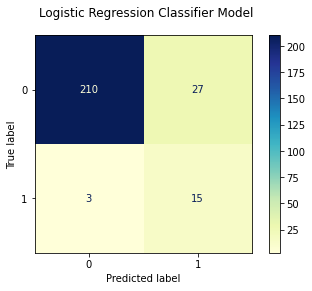

In [163]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression Classifier Model")

plot_confusion_matrix(grid_search_LR, X_test_sc[lr_cols], y_test, ax=ax, cmap="YlGnBu");

In [164]:
sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_sample(X_train_sc[lr_cols], y_train.ravel())

C = np.logspace(0, 1, 10)

params = dict(C=C, max_iter=[50, 100], class_weight = ['balanced', None])

logistic = LogisticRegression(penalty='l2', random_state=42)

grid_search_LR_sm = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = params, 
                              cv = 3, n_jobs = -1, verbose = 2)
grid_search_LR_sm.fit(X_train_res, y_train_res)

lr_train_preds_sm = grid_search_LR_sm.best_estimator_.predict(X_train_res)
lr_test_preds_sm = grid_search_LR_sm.best_estimator_.predict(X_test_sc[lr_cols])
metrics_score(lr_train_preds_sm, y_train_res, lr_test_preds_sm, y_test)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.0s


Training Accuracy:	0.9419 	Testing Accuracy:	0.8941
Training Precision:	0.9197 	Testing Precision:	0.3784
Training Recall:	0.9683 	Testing Recall:		0.7778
Training F1:		0.9434 	Testing F1:		0.5091


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.6s finished


## Decision Tree Modeling

### Baseline Model

In [165]:
DT = tree.DecisionTreeClassifier(random_state = 42, class_weight = 'balanced')


DT.fit(X_train_sc, y_train)

dt_train_preds = DT.predict(X_train_sc)
dt_test_preds = DT.predict(X_test_sc)
metrics_score(dt_train_preds, y_train, dt_test_preds, y_test)

Training Accuracy:	1.0 	Testing Accuracy:	0.9098
Training Precision:	1.0 	Testing Precision:	0.3684
Training Recall:	1.0 	Testing Recall:		0.3889
Training F1:		1.0 	Testing F1:		0.3784


Baseline Decision Tree model is very overfit

### RFE w/ Decision Tree

In [166]:
rfe_dt = RFECV(estimator=tree.DecisionTreeClassifier(class_weight = 'balanced'), step = 1, cv = 3, scoring = 'precision', n_jobs = -1, verbose = 1)
rfe_dt.fit(X_train_sc, y_train)
X_train_sc.columns[rfe_dt.get_support()]

Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 fe

Index(['FT', 'PER_1', 'VORP_2', 'rpg_3', 'spg_3', 'PER_3'], dtype='object')

In [167]:
dt_cols = ['FT', 'PER_1', 'WS_2', 'GS_2', 'VORP_2', 'rpg_3', 'spg_3', 'PER_3', 'season_year']

In [168]:
DT = tree.DecisionTreeClassifier(random_state = 42, class_weight = 'balanced')
DT.fit(X_train_sc[dt_cols], y_train)

DTbaserfe_train_preds = DT.predict(X_train_sc[dt_cols])
DTbaserfe_test_preds = DT.predict(X_test_sc[dt_cols])
metrics_score(DTbaserfe_train_preds, y_train, DTbaserfe_test_preds, y_test)

Training Accuracy:	1.0 	Testing Accuracy:	0.898
Training Precision:	1.0 	Testing Precision:	0.3182
Training Recall:	1.0 	Testing Recall:		0.3889
Training F1:		1.0 	Testing F1:		0.35


Baseline with RFE still very over fit

### Decision Tree w/ RFE + Gridsearch

In [169]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

params = dict(criterion=['gini', 'entropy'],
                max_depth=[2,4,6,8,10,12,15,20,25],
                 splitter = ['best', 'random'],
             )

DT = tree.DecisionTreeClassifier(random_state = 42, class_weight = 'balanced')

grid_search_DT = GridSearchCV(estimator=DT, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

grid_search_DT.fit(X_train_sc[dt_cols], y_train)

dtrfegs_train_preds = grid_search_DT.best_estimator_.predict(X_train_sc[dt_cols])
dtrfegs_test_preds = grid_search_DT.best_estimator_.predict(X_test_sc[dt_cols])
metrics_score(dtrfegs_train_preds, y_train, dtrfegs_test_preds, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.0s


Training Accuracy:	0.8978 	Testing Accuracy:	0.8706
Training Precision:	0.4024 	Testing Precision:	0.3333
Training Recall:	0.9167 	Testing Recall:		0.8333
Training F1:		0.5593 	Testing F1:		0.4762


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.3s finished


### Decision Tree w/ RFE + Grid Search + Resampling

In [170]:
sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_sample(X_train_sc[dt_cols], y_train.ravel())

criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

params = dict(criterion=['gini', 'entropy'],
                max_depth=[2,4,6,8,10,12,15,20,25],
                 splitter = ['best', 'random'],
             )

DT = tree.DecisionTreeClassifier(random_state = 42, class_weight = 'balanced')

grid_search_DT_sm = GridSearchCV(estimator=DT, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

grid_search_DT_sm.fit(X_train_res, y_train_res)

dtrfegssm_train_preds = grid_search_DT_sm.best_estimator_.predict(X_train_res)
dtrfegssm_test_preds = grid_search_DT_sm.best_estimator_.predict(X_test_sc[dt_cols])
metrics_score(dtrfegssm_train_preds, y_train_res, dtrfegssm_test_preds, y_test)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.3s


Training Accuracy:	0.9921 	Testing Accuracy:	0.9137
Training Precision:	0.9854 	Testing Precision:	0.4231
Training Recall:	0.9989 	Testing Recall:		0.6111
Training F1:		0.9921 	Testing F1:		0.5


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.6s finished


In [171]:
model_candidates = [
    
    {'name':'Logistic Regression',
     'accuracy score':accuracy_score(y_test, lrgsrfe_test_preds),
     'recall score' : recall_score(y_test, lrgsrfe_test_preds),
     'precision score' : precision_score(y_test,lrgsrfe_test_preds),
         'f1 score':metrics.f1_score(y_test, lrgsrfe_test_preds)},
    
    {'name':'Logistic Regression w/ Resampling',
     'accuracy score':accuracy_score(y_test, lr_test_preds_sm),
     'recall score' : recall_score(y_test, lr_test_preds_sm),
     'precision score' : precision_score(y_test,lr_test_preds_sm),
     'f1 score':metrics.f1_score(y_test, lr_test_preds_sm)},
    
    {'name':'Random Forest',
     'accuracy score':accuracy_score(y_test, rf_test_preds),
     'recall score' : recall_score(y_test, rf_test_preds,),
     'precision score' : precision_score(y_test,rf_test_preds),
    'f1 score':metrics.f1_score(y_test, rf_test_preds)},
    
    {'name':'Random Forest w/ Resampling',
     'accuracy score':accuracy_score(y_test, rf_test_preds_sm),
     'recall score' : recall_score(y_test, rf_test_preds_sm),
     'precision score' : precision_score(y_test,rf_test_preds_sm),
     'f1 score':metrics.f1_score(y_test, rf_test_preds_sm)},
    
    {'name':'Decision Tree',
     'accuracy score':accuracy_score(y_test, dtrfegs_test_preds),
     'recall score' : recall_score(y_test, dtrfegs_test_preds),
     'precision score' : precision_score(y_test,dtrfegs_test_preds),
     'f1 score':metrics.f1_score(y_test, dtrfegs_test_preds)},
    
    {'name':'Decision Tree w/ Resampling',
     'accuracy score':accuracy_score(y_test, dtrfegssm_test_preds),
     'recall score' : recall_score(y_test, dtrfegssm_test_preds),
     'precision score' : precision_score(y_test,dtrfegssm_test_preds),
     'f1 score':metrics.f1_score(y_test, dtrfegssm_test_preds)},
    
]


In [172]:
final_scores_df = pd.DataFrame(model_candidates).set_index('name')
final_scores_df

,accuracy score,recall score,precision score,f1 score
name,,,,
Logistic Regression,0.882353,0.833333,0.357143,0.500000
Logistic Regression w/ Resampling,0.894118,0.777778,0.378378,0.509091
Random Forest,0.952941,0.500000,0.750000,0.600000
Random Forest w/ Resampling,0.921569,0.722222,0.464286,0.565217
Decision Tree,0.870588,0.833333,0.333333,0.476190
Decision Tree w/ Resampling,0.913725,0.611111,0.423077,0.500000
